Milestone 1: You will submit a Jupyter notebook (Python 3) that implements following instructions:
1. Load the MRI volumes
2. Determine the pixel spacing and slice thickness of each loaded volume
3. Extract, visualize, and save middle coronal slices for all training+validation cases, including the MRIs and segmentations
(Hint: https://faculty.washington.edu/chudler/slice.html)

In [1]:
#Pesky import stuff
%matplotlib inline

import numpy as np
import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import math
import cmath
from scipy import ndimage
import random
import cv2
from scipy import signal
import nibabel as nib
from scipy.ndimage import rotate

First I'm gonna try do this with just one image and then I will do it for everything

Source for all the following: https://nipy.org/nibabel/coordinate_systems.html

In [4]:
#load an image (OSX) - in this case testing IBSR_08
#im = nib.load('/Users/rpellumbi/Desktop/DSP_PROJECT_DATA/Testing/IBSR_08/images/analyze/IBSR_08_ana.img')

#Load the image (Windows)
im = nib.load(r'C:\Users\Rami Pellumbi\Desktop\DSP_PROJECT_DATA\Testing\IBSR_08\images\analyze\IBSR_08_ana.img')
#get img data and shape
epi_img_data = im.get_fdata()
epi_img_data.shape

(256, 256, 128, 1)

Source for getting pixel/slice spacing: https://nipy.org/nibabel/nibabel_images.html

In [5]:
#get the voxel sizes in millimeters
size = im.header.get_zooms()

#Note: size has four elements. The fourth element is the time between scans in milliseconds

x = size[0] #pixel width
y = size[1] #pixel height
z = size[2] #pixel thickness

print('width = {}mm, height = {}mm, thickness =  {}mm'.format(x,y,z))
print(size)

width = 1.0mm, height = 1.0mm, thickness =  1.5mm
(1.0, 1.0, 1.5, 0.0)


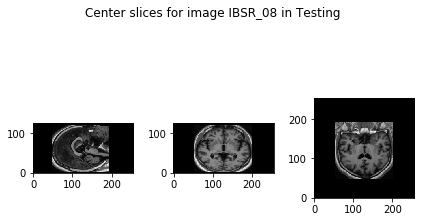

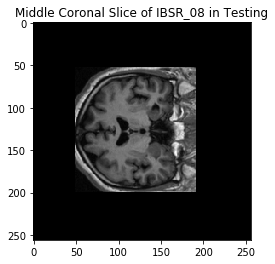

In [6]:
"""Function to display row of image slices"""
def show_slices(slices):
    fig, axes = plt.subplots(1, len(slices))
    for i, slice in enumerate(slices):
        #made a change to original function by adding squeeze() as without it the image would not plot
        #solution from googling the issue
        axes[i].imshow(slice.T.squeeze(), cmap = 'gray', origin="lower")
        #clean up the image plots
        fig.tight_layout(rect=[0, 0.03, 1, 0.95])
        
#define slices similar to source
slice_0 = epi_img_data[128, :, :] #note this is len(epi_img_data)//2
slice_1 = epi_img_data[:, 128, :] #note this is len(epi_img_data[0])//2
slice_2 = epi_img_data[:, :, 64] #note this is len(epi_img_data[0][0])//2
show_slices([slice_0, slice_1, slice_2])
plt.suptitle("Center slices for image IBSR_08 in Testing") 

#NOTE: slice_2 is the middle coronal slice! So we only need to plot that for this milestone going forward!
#How do I know this is the Coronal section? https://faculty.washington.edu/chudler/slice.html
plt.figure()
plt.title('Middle Coronal Slice of IBSR_08 in Testing')
plt.imshow(slice_2.squeeze(), cmap = 'gray')

# Everything up to this point was just practice. Milestone 1 begins here. Now lets do this for all images!

First lets write a function that determines the pixel spacing for each loaded volume and another function that prints the middle coronal slice for that volume.

In [7]:
"""Spacing takes a nibabel loaded image and returns its pixel and slice thickness"""
def spacing(nib_img):
    size = nib_img.header.get_zooms()
    #Note: size has four elements. The fourth element is the time between scans in milliseconds
    x = size[0] #pixel width
    y = size[1] #pixel height
    z = size[2] #pixel thickness
    return 'width = {}mm, height = {}mm, thickness =  {}mm'.format(x,y,z)

    
"""MiddleCoronalSlice takes a nib_img and prints its coronal slice"""
def MiddleCoronalSlice(nib_img):
    nib_img_data = nib_img.get_fdata()
    slice_2 = nib_img_data[:, :, len(nib_img_data[0][0])//2]
    #rotate the slice 90 degrees so it looks more like the websites photo
    rot_slice_2 = rotate(slice_2, 90)
    plt.imshow(rot_slice_2.squeeze(), cmap = 'gray', origin="lower")

 Loading the MRI volumes.

In [17]:
#Location of training images and segments to load (OSX)
#training_images_dir = ['/Users/rpellumbi/Desktop/DSP_PROJECT_DATA/Training/IBSR_0'+ str(i) + '/images/analyze/IBSR_0' + str(i) +'_ana.img' for i in range(1,7)]
#training_segments_dir = ['/Users/rpellumbi/Desktop/DSP_PROJECT_DATA/Training/IBSR_0'+ str(i) + '/segmentation/analyze/IBSR_0' + str(i) +'_seg_ana.img' for i in range(1,7)]

#Location of training images and segments to load (Windows)
training_images_dir = [r'C:\Users\Rami Pellumbi\Desktop\DSP_PROJECT_DATA\Training\IBSR_0'+ str(i) + r'\images\analyze\IBSR_0' + str(i) + r'_ana.img' for i in range(1,7)]
training_segments_dir = [r'C:\Users\Rami Pellumbi\Desktop\DSP_PROJECT_DATA\Training\IBSR_0'+ str(i) + r'\segmentation\analyze\IBSR_0' + str(i) + r'_seg_ana.img' for i in range(1,7)]


#location of validation images and segments to load(OSX)
#validation_images_dir = ['/Users/rpellumbi/Desktop/DSP_PROJECT_DATA/Validation/IBSR_'+ i + '/images/analyze/IBSR_' + i +'_ana.img' for i in ['07', '15']]
#validation_segments_dir = ['/Users/rpellumbi/Desktop/DSP_PROJECT_DATA/Validation/IBSR_'+ i + '/segmentation/analyze/IBSR_' + i +'_seg_ana.img' for i in ['07', '15']]

#location of validation images and segments to load(Windows)
validation_images_dir = [r'C:\Users\Rami Pellumbi\Desktop\DSP_PROJECT_DATA\Validation\IBSR_'+ i + r'\images\analyze\IBSR_' + i + r'_ana.img' for i in ['07', '15']]
validation_segments_dir = [r'C:\Users\Rami Pellumbi\Desktop\DSP_PROJECT_DATA\Validation\IBSR_'+ i + r'\segmentation\analyze\IBSR_' + i + r'_seg_ana.img' for i in ['07', '15']]

#location of testing images
testing_images_loc = ['08','09','10','11','12','13','14','16','17']
#where the directory of testing images will be stored
testing_images_dir = []

#OSX
# for loc in testing_images_loc:
#     testing_images_dir.append('/Users/rpellumbi/Desktop/DSP_PROJECT_DATA/Testing/IBSR_'+ loc + '/images/analyze/IBSR_' + loc + '_ana.img')
    
#WINDOWS
for loc in testing_images_loc:
    testing_images_dir.append(r'C:\Users\Rami Pellumbi\Desktop\DSP_PROJECT_DATA\Testing\IBSR_'+ loc + r'\images\analyze\IBSR_' + loc + '_ana.img')

#arrays of training images and segments
training_images = []
training_segments = []

#arrays of validation images and segments
validation_images = []
validation_segments = []

#array of testing images
testing_images = []

#BY DEFINITION there are an equal amount of images as there are segments so arrays are the same size and can therefore be 

#load up all the training images and segments in order
for i in range(len(training_images_dir)):
    training_images.append(nib.load(training_images_dir[i]))
    training_segments.append(nib.load(training_segments_dir[i]))

#load up all the validation images in order
for i in range(len(validation_images_dir)):
    validation_images.append(nib.load(validation_images_dir[i]))
    validation_segments.append(nib.load(validation_segments_dir[i]))

#load up all testing images in order
for directory in testing_images_dir:
    testing_images.append(nib.load(directory))

# Now that we have all of the training and validation images lets get the spacing and coronal slice of each.

#### First lets do spacing of just testing images - since we don't need images of those for this milestone (images shown anyways)

Spacing of Testing Image IBSR_08: width = 1.0mm, height = 1.0mm, thickness =  1.5mm
Spacing of Testing Image IBSR_09: width = 1.0mm, height = 1.0mm, thickness =  1.5mm
Spacing of Testing Image IBSR_10: width = 1.0mm, height = 1.0mm, thickness =  1.5mm
Spacing of Testing Image IBSR_11: width = 1.0mm, height = 1.0mm, thickness =  1.5mm
Spacing of Testing Image IBSR_12: width = 1.0mm, height = 1.0mm, thickness =  1.5mm
Spacing of Testing Image IBSR_13: width = 0.9375mm, height = 0.9375mm, thickness =  1.5mm
Spacing of Testing Image IBSR_14: width = 0.9375mm, height = 0.9375mm, thickness =  1.5mm
Spacing of Testing Image IBSR_16: width = 0.8370535969734192mm, height = 0.8370535969734192mm, thickness =  1.5mm
Spacing of Testing Image IBSR_17: width = 0.8370535969734192mm, height = 0.8370535969734192mm, thickness =  1.5mm


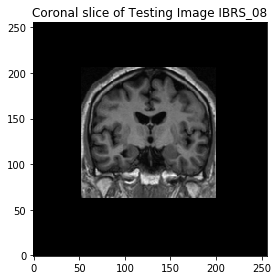

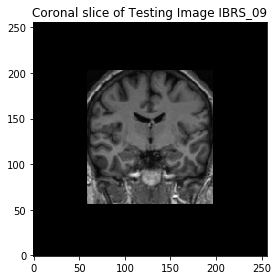

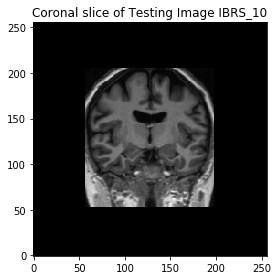

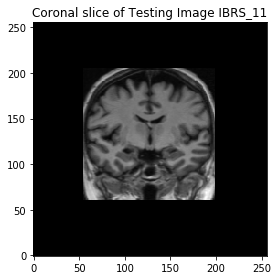

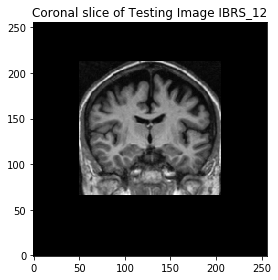

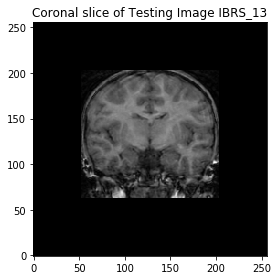

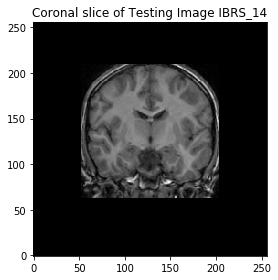

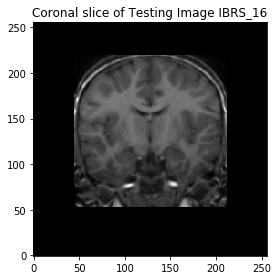

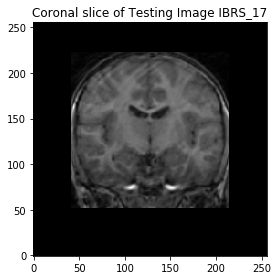

In [18]:
"""Spacing and Coronal Slice of Testing images (08-14,16,17)"""
#titles of each image for later
titles = ['08','09','10','11','12','13','14','16','17']
#for each image in training images
for i in range(len(testing_images)):
    #compute the spacing
    print('Spacing of Testing Image IBSR_' + titles[i] + ': ' + spacing(testing_images[i]))
    
    plt.figure()
    #plot middle coronal slice
    MiddleCoronalSlice(testing_images[i])
    plt.title('Coronal slice of Testing Image IBRS_' + titles[i])
    plt.tight_layout()

#### Now lets do spacing and Coronal slice of Training and Validation images/segments

Spacing of Training Image IBSR_01: width = 0.9375mm, height = 0.9375mm, thickness =  1.5mm
Spacing of Training Image IBSR_02: width = 0.9375mm, height = 0.9375mm, thickness =  1.5mm
Spacing of Training Image IBSR_03: width = 0.9375mm, height = 0.9375mm, thickness =  1.5mm
Spacing of Training Image IBSR_04: width = 0.9375mm, height = 0.9375mm, thickness =  1.5mm
Spacing of Training Image IBSR_05: width = 0.9375mm, height = 0.9375mm, thickness =  1.5mm
Spacing of Training Image IBSR_06: width = 0.9375mm, height = 0.9375mm, thickness =  1.5mm


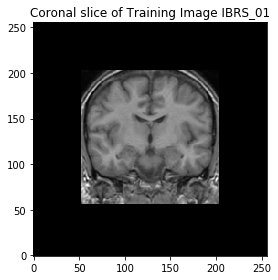

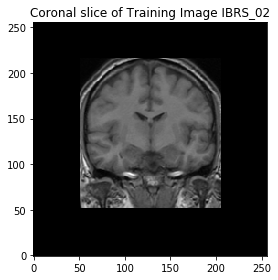

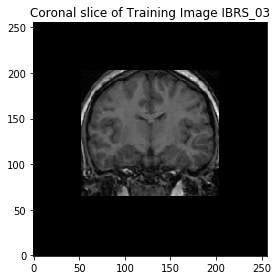

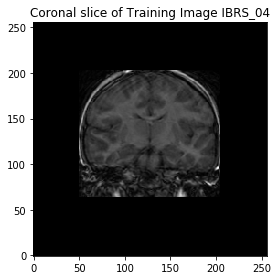

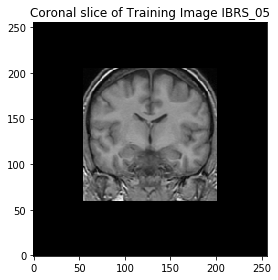

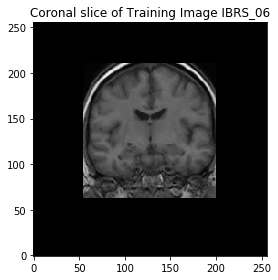

In [19]:
"""Spacing and Coronal Slice of training images (01-06)"""
#titles of each image for later
titles = ['01','02','03','04','05','06']
#for each image in training images
for i in range(len(training_images)):
    #compute the spacing
    print('Spacing of Training Image IBSR_' + titles[i] + ': ' + spacing(training_images[i]))
    
    plt.figure()
    #plot middle coronal slice
    MiddleCoronalSlice(training_images[i])
    plt.title('Coronal slice of Training Image IBRS_' + titles[i])
    plt.tight_layout()

Spacing of Training Segment IBSR_01: width = 0.9375mm, height = 0.9375mm, thickness =  1.5mm
Spacing of Training Segment IBSR_02: width = 0.9375mm, height = 0.9375mm, thickness =  1.5mm
Spacing of Training Segment IBSR_03: width = 0.9375mm, height = 0.9375mm, thickness =  1.5mm
Spacing of Training Segment IBSR_04: width = 0.9375mm, height = 0.9375mm, thickness =  1.5mm
Spacing of Training Segment IBSR_05: width = 0.9375mm, height = 0.9375mm, thickness =  1.5mm
Spacing of Training Segment IBSR_06: width = 0.9375mm, height = 0.9375mm, thickness =  1.5mm


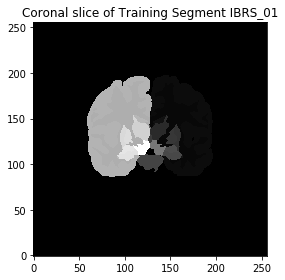

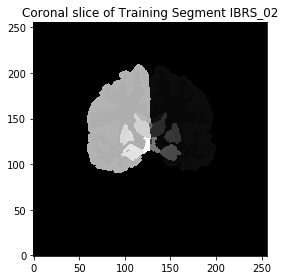

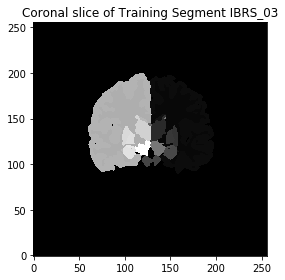

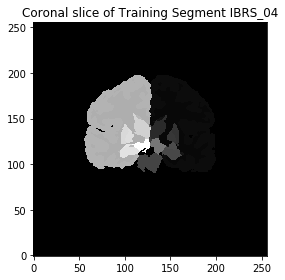

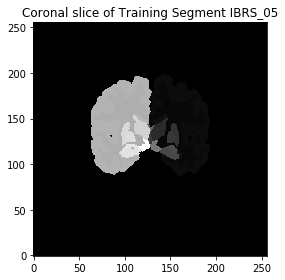

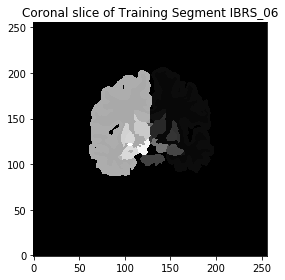

In [20]:
"""Spacing and Coronal Slice of training segments (01-06)"""
#titles of each image for later
titles = ['01','02','03','04','05','06']
#for each image in training images
for i in range(len(training_segments)):
    #compute the spacing
    print('Spacing of Training Segment IBSR_' + titles[i] + ': ' + spacing(training_segments[i]))
    
    plt.figure()
    #plot middle coronal slice
    MiddleCoronalSlice(training_segments[i])
    plt.title('Coronal slice of Training Segment IBRS_' + titles[i])
    plt.tight_layout()

Spacing of Validation Image IBSR_07: width = 1.0mm, height = 1.0mm, thickness =  1.5mm
Spacing of Validation Image IBSR_15: width = 0.8370535969734192mm, height = 0.8370535969734192mm, thickness =  1.5mm


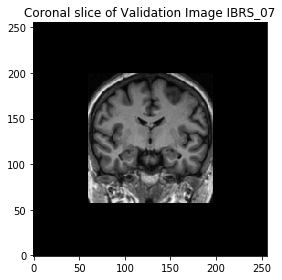

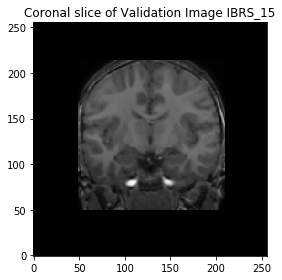

In [21]:
"""Spacing and Coronal Slice of Validation images (07,15)"""
#titles of each image for later
titles = ['07','15']
#for each image in training images
for i in range(len(validation_images)):
    #compute the spacing
    print('Spacing of Validation Image IBSR_' + titles[i] + ': ' + spacing(validation_images[i]))
    
    plt.figure()
    #plot middle coronal slice
    MiddleCoronalSlice(validation_images[i])
    plt.title('Coronal slice of Validation Image IBRS_' + titles[i])
    plt.tight_layout()

Spacing of Validation Segment IBSR_07: width = 1.0mm, height = 1.0mm, thickness =  1.5mm
Spacing of Validation Segment IBSR_15: width = 0.8370535969734192mm, height = 0.8370535969734192mm, thickness =  1.5mm


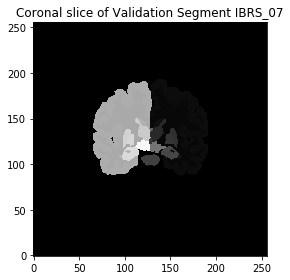

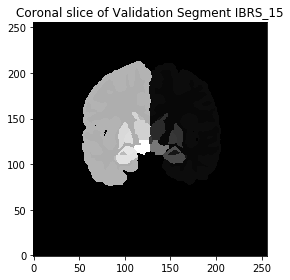

In [22]:
"""Spacing and Coronal Slice of Validation segments (07,15)"""
#titles of each image for later
titles = ['07','15']
#for each image in training images
for i in range(len(validation_segments)):
    #compute the spacing
    print('Spacing of Validation Segment IBSR_' + titles[i] + ': ' + spacing(validation_segments[i]))
    
    plt.figure()
    #plot middle coronal slice
    MiddleCoronalSlice(validation_segments[i])
    plt.title('Coronal slice of Validation Segment IBRS_' + titles[i])
    plt.tight_layout()